<center> <h1> The Assignment for SFR job </h1> </center>

## Name : Radwan SATOUF 
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––



## Outline

- [Exercise 1](#ex1)
    - [Objective](#1.1)
    - [More Technically](#1.2)
- [Solution for exercice 1](#sol1)
    - [Getting all data](#sol1.1)
    - [Analyzing and preprocessing](#sol1.2)
    - [Modeling and predicting ](#sol1.3)
- [Exercice 2 : SQL](#ex2)
- [Solution for exercice 2](#sol2)
- [# Exercice 3 : Mathématiques](#ex3)

# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


<a name='ex1'></a>

# Exercise 1 : Can I find my invoices and contracts?

<u>**NB : All data used in this exercise are fictitious data.**</u>


<a name='1.1'></a>
## Objective:

Each year, the accounting management service is scaning thousands of invoices and contracts. All these pdf scans are stored in a Database, and manually flaged. The accounting service wants to automate the process.

*Given a bunch of documents without label are you able to separate invoices from contracts?*

As a Data Scientist you offer to implement a machine learning solution. Nonetheless, accounting services bring to your attention:
 - Formats are constantly evolving therefore, you cannot use past documents to design your solution
 - They will send you TEXT data after passing pdf into an OCR (noise may happen)
 

<a name='1.2'></a>
## More Technically
 - **/train** folder contains raw text invoices and contracts (0000.txt to 0799.txt)
 - **/val** folder contains raw text invoices and contracts (0000.txt to 0799.txt) and *label.csv* to evaluate performances.
 
You are asked to:
 - Build a machine learning process to seperate invoices from contracts without previous knowledge.
 - Evaluate the performances on the validation (/val) dataset.
 
*Feel free to import any usual python and ML packages.*

*Please answer in English*

<a name='sol1'></a>
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Solution for exercice 1
## Importing all the Important packages :

In [1]:
#data manipulation 
import pandas as pd
import numpy as np
from glob import glob as gl #to read files

# String manipulation
import re
import string 

# Modeling 
from sklearn.feature_extraction.text import TfidfVectorizer #from TF-Idf transformer 
from sklearn.cluster import KMeans # clustering 
from sklearn.decomposition import PCA # to show Dimensions 

#Model Evaluation
from sklearn.metrics import classification_report

#Threading 
from concurrent.futures import ThreadPoolExecutor

#Visualization set up 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")#seting theme for graphs
#TODO

<a name='#sol1.1'></a>
## Getting all data
* First I am going to get the directory of the files
* Seconde I am using glob Package to get all files names 
* Then I am creating 3 variables 
    * trainFiles : all the training text 
    * valFiles : all the validation text 
    * valCSV : a data frame with name and label of  the validation dataset to evaluate the performances

In [2]:
ls data/

train/ val/


In [3]:
trainFiles=gl("data/train/*.txt") # getting all the names train files end with .txt
print(f"trainFiles got {len(trainFiles)} files")
valFiles=gl("data/val/*.txt") # getting all the names train files end with .txt
valCSV=pd.read_csv(gl("data/val/*.csv")[0])
print(f"valFiles got {len(trainFiles)} files\n")
print(f"The last 3 files of trainFiles :{trainFiles[:5]}")# geting the firts 5 files
valCSV.tail(3)

trainFiles got 800 files
valFiles got 800 files

The last 3 files of trainFiles :['data/train/0359.txt', 'data/train/0371.txt', 'data/train/0417.txt', 'data/train/0403.txt', 'data/train/0365.txt']


,name,label
1997,1997,facture
1998,1998,facture
1999,1999,facture


<a name ="#sol1.2"></a>
## Analyzing the data set 
* We can note that we have 800 validations files and the in data frame there is 2000 name files.
* Next we are going to check for the missing values and understand what are the 2000 names 

In [5]:
valCSV.info()
print("")
print(valCSV.label.value_counts())
valCSV.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2000 non-null   int64 
 1   label   2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

facture    1600
contrat     400
Name: label, dtype: int64


,name
count,2000.000000
mean,999.500000
std,577.494589
min,0.000000
25%,499.750000
50%,999.500000
75%,1499.250000
max,1999.000000


* As we see above there is no missing values but there is extra data 
* There is 1600 facture 
* There is 400 contrat 

In [7]:
def preprocessing(doc,label=None):
    """This function will preprocess and clean the text
    
    Args:
        doc (string): a given document
        d_model (booling, optional): if the data set is labeld 
    Returns:
        string or list of two string: a preprocessed text
    """
    with open(doc, 'r') as text:
         doc_ = text.read()# reading files 
    doc_ = doc_.lower() # lowercasing 
    #using translate to replace so values with the character described in a dictionary to remove punctuation
    doc_ = doc_.translate(str.maketrans('', '', string.punctuation)) 
    doc_ = re.sub(r'\n',' ',doc_) #removing  lines
    doc_ = re.sub(r'\t',' ',doc_)#removing  tabs
    doc_ = re.sub(r'\d+',' NUM ',doc_) #numbers have no meaning values in our case so we can replace them
    doc_ = ' '.join(doc_.split())# removing extra sapces
    if label:
        return [doc_,int(doc.split("/")[-1][:-4])]#if it is the val set than get their names
        #not it important to get the doc preprocessed and its name beacause when using threading the 
        #data are not in order. 
    return doc_

## Strategy 
* I am using Multi threading and a generator to accelerate the importing and the preprocessing of the Documents 
* Than I am using TF-idf vectorizing technique for word embadding
    * Since TF-IDF weights words based on relevance, it will help to determine that the words with the highest relevance are the most important. It simply determine keywords for a document
    * The task seems not that hard so I am using max_features 500 (plus, I checked with PCA visualisation and KMeans with 500 feautres it dose sepreate the two classes well) and no need to consume time and energy for higher values.
    * As well i have decided to make nGram from 1 to 3 words

I wanted to use more sophisticated algorithms for word embedding with Artificial neulal network to make word embedding with 300 dimensions but it is ok with one hot encoding using TF-idf word vectorizing for this problem 

### Uesig Threading for the train set to be preprocessed

In [8]:
with ThreadPoolExecutor() as execu:
    trainClean= execu.map(preprocessing, trainFiles)# preprocessing train set
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,3)).fit(trainClean)#Tfidf transform
with ThreadPoolExecutor() as execu:
    trainClean= execu.map(preprocessing, trainFiles)# re iterting for the tranforme 

### Uesig Threading for the val set to be preprocessed 

In [9]:
is_true=[1]*len(valFiles)
with ThreadPoolExecutor() as execu:
    testClean= execu.map(preprocessing,valFiles,is_true)
testClean=np.array(list(testClean)) #transform to numpy array to get individual names 

### Train set is transforming and it looks like  : 

In [10]:
X_train_T=tfidf_vectorizer.transform(trainClean)
X_train=pd.DataFrame.sparse.from_spmatrix(X_train_T)# geting the data transformed from spmatrix to data frame 
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.010625,0.020776,0.000000,0.000000,0.021277,0.000000,0.029423,0.000000,0.013730,0.022348,...,0.000000,0.000000,0.011273,0.013333,0.010639,0.011146,0.017656,0.022096,0.010056,0.013841
1,0.021655,0.021172,0.013788,0.000000,0.010841,0.020857,0.019989,0.013569,0.013992,0.022774,...,0.000000,0.013286,0.022976,0.000000,0.010841,0.022716,0.017992,0.022517,0.020495,0.000000
2,0.010313,0.020167,0.013133,0.013133,0.010326,0.019866,0.028559,0.000000,0.013327,0.010846,...,0.013063,0.012655,0.010942,0.000000,0.010326,0.000000,0.000000,0.010723,0.019521,0.013435
3,0.000000,0.030884,0.013408,0.000000,0.010543,0.020283,0.029158,0.013196,0.000000,0.022147,...,0.013337,0.012920,0.011172,0.013213,0.021086,0.011046,0.000000,0.010948,0.009965,0.013717
4,0.010814,0.021146,0.000000,0.013770,0.021655,0.000000,0.009982,0.013552,0.000000,0.011373,...,0.000000,0.013269,0.022947,0.013570,0.021655,0.034032,0.035939,0.011244,0.020469,0.014087


### Val set transforming 

In [11]:
X_test_T=tfidf_vectorizer.transform(testClean[:,0])
X_test=pd.DataFrame.sparse.from_spmatrix(X_test_T) #geting the data transformed from spmatrix to data frame 
#geting the val set preprocessed
X_test_index=testClean[:,1]# geting the names 

<a name ="#sol1.3"></a>
## Modeling and predicting 

### Fitting the model with k-means chossing two clusters 

In [12]:
model=KMeans(n_clusters=2,random_state=42,algorithm="auto")
model.fit(X_train)

KMeans(n_clusters=2, random_state=42)

### Here I am just testing on 2000 features using PCA and K-means
It seems very powerful but is it necessary ? 

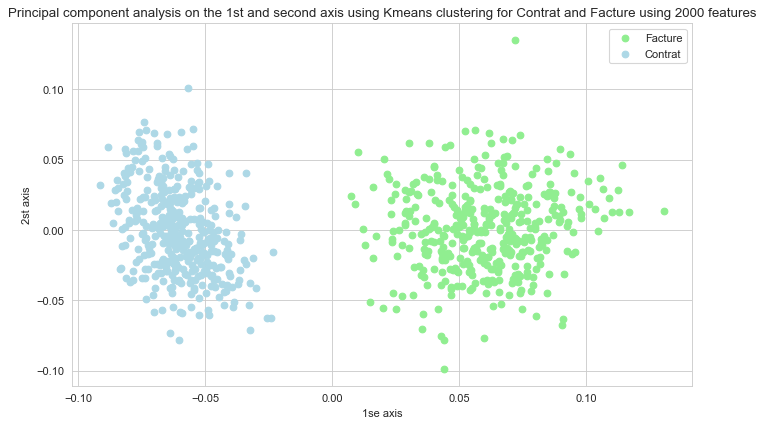

In [13]:
# re Applying the preprocessing with 20000
with ThreadPoolExecutor() as execu:
    trainClean= execu.map(preprocessing, trainFiles)
tfidf_vectorizer2 = TfidfVectorizer(max_features=2000, ngram_range=(1,3)).fit(trainClean)
with ThreadPoolExecutor() as execu:
    trainClean= execu.map(preprocessing, trainFiles)
X_train_T2=tfidf_vectorizer2.transform(trainClean)
X_train2=pd.DataFrame.sparse.from_spmatrix(X_train_T2)

# apply PCA and K-means 
pca = PCA(2)
#Transform the data
df = pca.fit_transform(X_train2.values)
KMea=KMeans(n_clusters=2,random_state=42)
label = KMea.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0] #Facture
filtered_label1 = df[label == 1]
#Plotting the results
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'lightgreen',label="Facture")
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'lightblue',label="Contrat")
plt.legend()
plt.title("Principal component analysis on the 1st and second axis using Kmeans clustering for Contrat and Facture using 2000 features")
plt.ylabel("2st axis")
plt.xlabel("1se axis")
plt.show()

### Well 500 features is good enough to get a great result and much faster

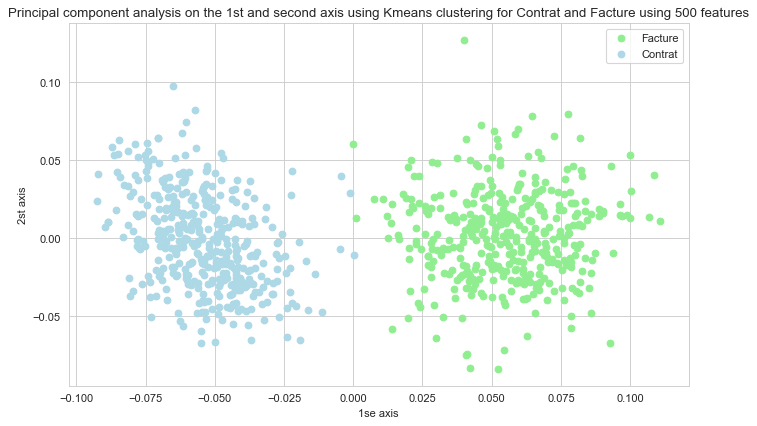

In [14]:
# apply PCA and K-means 
pca = PCA(2)
#Transform the data
df = pca.fit_transform(X_train.values)
KMea=KMeans(n_clusters=2,random_state=42)
label = KMea.fit_predict(df)
#filter rows of original data
filtered_label0 = df[label == 0]
filtered_label1 = df[label == 1]
#Plotting the results
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(filtered_label0[:,0] , filtered_label0[:,1] , color = 'lightgreen',label="Facture")
plt.scatter(filtered_label1[:,0] , filtered_label1[:,1] , color = 'lightblue',label="Contrat")
plt.legend()
plt.title("Principal component analysis on the 1st and second axis using Kmeans clustering for Contrat and Facture using 500 features")
plt.ylabel("2st axis")
plt.xlabel("1se axis")
plt.show()

### Now we can predict the val set and check the results 

In [15]:
test_labels = model.predict(X_test)# predict 
testData=pd.DataFrame({"name":X_test_index}) #creating dataframe for text index from val set
testData['clusters'] = test_labels # adding the labels 
valCSV['name']=valCSV.name.astype("str")#Making "name" type a string to match with prediction data 
X_test_clstrs=testData.merge(valCSV,on="name" ,how ="left") #Merging on the available val data on the name 
X_test_clstrs

,name,clusters,label
0,359,1,contrat
1,371,1,contrat
2,417,0,facture
3,403,0,facture
4,365,1,contrat
...,...,...,...
795,368,1,contrat
796,340,1,contrat
797,426,0,facture
798,432,0,facture


In [16]:
X_test_clstrs["label_pred"]=X_test_clstrs.clusters.map({1:"contrat",0:"facture"})#re naming the pred labels 
X_test_clstrs.head()


,name,clusters,label,label_pred
0,359,1,contrat,contrat
1,371,1,contrat,contrat
2,417,0,facture,facture
3,403,0,facture,facture
4,365,1,contrat,contrat


### Getting the performance 

In [17]:
print(classification_report(X_test_clstrs.label,X_test_clstrs.label_pred))

              precision    recall  f1-score   support

     contrat       1.00      1.00      1.00       400
     facture       1.00      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



### Incredible result I want to see if there is problme or is the model is very good because its quit rare to have 100% accuracy 

In [20]:
# checking many values
with open(valFiles[50], 'r') as test:
        print(test)
        test = test.read()
        print(test[:200])
X_test_clstrs[X_test_clstrs.name=="158"]

<_io.TextIOWrapper name='data/val/0158.txt' mode='r' encoding='UTF-8'>
SFR
Contrat factif no. 217159

Résumé des offres de vot*e contrat:
SFR *OBILE 5G
SFR ADSL

Résumé deszéquipement de votre conorat:
Television LG 42"
APPLE iltone
Semsung Galaxy
SwR BOX 7!
Résumé des o


,name,clusters,label,label_pred
50,158,1,contrat,contrat


## Results  

### - As we can see there is 400 "contrat" label and 400 "facture" label
### - The model got 100% accuracy for f1-Score the model performes Excellent !
### - 100% right for the recall and 100% for the precision the model can predict well the "contrat" and the "facure" 

# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<a name='ex2'></a>


# Exercice 2 : SQL

Vous travaillez chez un revendeur et disposez de deux tables **PRODUCTS** et **SALES** contenant les produits et les ventes réalisées. Ci-dessous les schémas et quelques exemples

**PRODUCTS**
- Product : STRING, PRIMARY KEY, contient le nom du produit
- Price : INT, contient le coût en euro du produit

| Product | Price |
|:-: | :-: |
| A | 100 | 
| B | 250 |
|...|...|

**SALES**
- Order_ID : STRING, contient l'identifiant de l'achat
- Product : STRING, contient le nom du produit

| Order_ID | Product |
|:-: | :-: |
| a12f3 | A | 
| a12f3 | C |
| b57g6 | B |
|...|...|

**1)** Ecrire une requete SQL retournant les *Order_ID* dans lesquels un produit coûtant 100 euros a été acheté <br>
**2)** Ecrire une requete SQL retournant les *Order_ID* dont le coût global de l'achat est d'au moins 200 euros

<a name='sol2'></a>
# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Solution for exercice 2
## Importing all the Important packages :

1. Une requete SQL retournant les Order_ID dans lesquels un produit coûtant 100 euros a été acheté 

``` mysql
SELECT Order_ID
FROM SALES  INNER JOIN PRODUCTS
ON SALES.Product = PRODUCTS.Product
WHERE Price = 100;
```

2. Une requete SQL retournant les Order_ID dont le coût global de l'achat est d'au moins 200 euros

``` mysql
SELECT Order_ID, SUM_
FROM (
SELECT Order_ID,SUM(Price) as SUM_ 
FROM SALES  INNER JOIN PRODUCTS
ON SALES.Product = PRODUCTS.Product
GROUP BY Order_ID)
WHERE SUM_ >= 200;
```


# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

<a name="ex3"></a>
# Exercice 3 : Mathématiques

Soit $(E, \langle , \rangle )$ un espace euclidien. On note $(e_1, \dots, e_n)$ une base orthonormée de $E$.<br>
Soit $f \in \mathcal{L}(E)$ telle que

<center> $\forall x,y \in E, \hspace{1cm} \langle x,y \rangle = 0 \Rightarrow \langle f(x),f(y) \rangle = 0 $ </center>

<br><br>

**1)** Montrer que $\forall i \neq j$, $||f(e_i)|| = ||f(e_j)||$ <br></br>
*Indication : on pourra considérer* $u = e_i + e_j$ et $v = e_i - e_j$

**2)** On suppose $f \neq 0$, montrer qu'il existe $\lambda > 0$ telle que $\forall x \in E$, $ ||f(x)|| = \lambda ||x||$ <br></br>
*Indication : on pourra écrire* $x = \sum x_i e_i$

<br>

*Réponse attendue en français*

# ––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

Désolé ca fait longtemps je n'ai pas fait d'algèbre théorique. je ne me rapple plus comment prouver que les normes sont égaux quand le produit scalaire de ces deux fonction est nul.